In [1]:
import glob
import torch
import torch.nn as nn
import numpy as np
from torch.utils.data.dataset import Dataset
import matplotlib.pyplot as plt
from PIL import Image
from tqdm.auto import tqdm
from torchvision.transforms import ToPILImage
from torch.optim.adam import Adam
from torch.utils.data.dataloader import DataLoader
import torchvision.models as models
import random
import os
import cv2
import albumentations as A
from albumentations.pytorch import ToTensorV2
from IPython.core.debugger import set_trace
import pandas as pd
import datetime
import pytz
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2
import re
import torch.nn.functional as F

/opt/conda/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 파라미터 설정

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [3]:
'''
# 맥 mps 설정
device = torch.device("mps:0" if torch.backends.mps.is_available() else "cpu")
print(f"현재 디바이스는 {device} 입니다.")
'''

'\n# 맥 mps 설정\ndevice = torch.device("mps:0" if torch.backends.mps.is_available() else "cpu")\nprint(f"현재 디바이스는 {device} 입니다.")\n'

In [4]:
CFG = {
    'IMG_SIZE':1024,
    'EPOCHS':5,
    'LEARNING_RATE':1e-4,
    'BATCH_SIZE': 32,
    'SEED':41,
    'MEAN' : [0.485, 0.456, 0.406],
    'STD'  : [0.229, 0.224, 0.225],
    'train_magnification':"20X"
}

In [5]:
kst = pytz.timezone('Asia/Seoul')
current_datetime = datetime.datetime.now(kst)
day = current_datetime.strftime("%Y_%m_%d")
hour = current_datetime.strftime("%I:%M_%p")
print(day, hour)

2023_07_04 05:58_PM


In [6]:
# server path
output_path = f"/workspace/gitignore/output/{day}"
pth_path = f"/workspace/gitignore/pthfile/{day}"
trainframe_path = f"{output_path}/trainframe"
train_data_path = f"/workspace/gitignore/PDA_mask_img(1024)/train/{CFG['train_magnification']}/**/*.png"
val_data_path = f"/workspace/gitignore/PDA_mask_img(1024)/validation/{CFG['train_magnification']}/**/*.png"

In [7]:
# server output name
trainframe_name = f"{trainframe_path}/train:{CFG['train_magnification']}_epoch:{CFG['EPOCHS']}_{hour}.xlsx"
pth_name=f"{pth_path}/train:{CFG['train_magnification']}_epoch:{CFG['EPOCHS']}_{hour}.pth"

In [8]:
# local path
'''
output_path = f"git_ignore/output/{day}"
pth_path = f"git_ignore/pthfile/{day}"
trainframe_path = f"{output_path}/trainframe"
train_data_path = f"git_ignore/PDA_mask_img/train/{CFG['train_magnification']}/**/*.png"
val_data_path = f"git_ignore/PDA_mask_img/validation_mask/{CFG['train_magnification']}/**/*.png"
'''

'\noutput_path = f"git_ignore/output/{day}"\npth_path = f"git_ignore/pthfile/{day}"\ntrainframe_path = f"{output_path}/trainframe"\ntrain_data_path = f"git_ignore/PDA_mask_img/train/{CFG[\'train_magnification\']}/**/*.png"\nval_data_path = f"git_ignore/PDA_mask_img/validation_mask/{CFG[\'train_magnification\']}/**/*.png"\n'

In [9]:
# local output name
'''
trainframe_name = f"{trainframe_path}/train:{CFG['train_magnification']}_epoch:{CFG['EPOCHS']}_{hour}.xlsx"
pth_name=f"{pth_path}/train:{CFG['train_magnification']}_epoch:{CFG['EPOCHS']}_{hour}.pth"
'''

'\ntrainframe_name = f"{trainframe_path}/train:{CFG[\'train_magnification\']}_epoch:{CFG[\'EPOCHS\']}_{hour}.xlsx"\npth_name=f"{pth_path}/train:{CFG[\'train_magnification\']}_epoch:{CFG[\'EPOCHS\']}_{hour}.pth"\n'

In [10]:
# 시드 고정
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(CFG['SEED']) # Seed 고정

## 데이터 경로지정

In [11]:
train_path_list = sorted(glob.glob(train_data_path))
train_mask_path = train_path_list[0::2]
train_img_path = train_path_list[1::2]
train_mask_path[:5]

['/workspace/gitignore/PDA_mask_img(1024)/train/20X/C3L-00017-22/C3L-00017-22 [d=1.01174,x=10073,y=10073,w=1036,h=1036]-labelled.png',
 '/workspace/gitignore/PDA_mask_img(1024)/train/20X/C3L-00017-22/C3L-00017-22 [d=1.01174,x=10073,y=10603,w=1036,h=1036]-labelled.png',
 '/workspace/gitignore/PDA_mask_img(1024)/train/20X/C3L-00017-22/C3L-00017-22 [d=1.01174,x=10073,y=11133,w=1036,h=1036]-labelled.png',
 '/workspace/gitignore/PDA_mask_img(1024)/train/20X/C3L-00017-22/C3L-00017-22 [d=1.01174,x=10073,y=11663,w=1036,h=1036]-labelled.png',
 '/workspace/gitignore/PDA_mask_img(1024)/train/20X/C3L-00017-22/C3L-00017-22 [d=1.01174,x=10073,y=12193,w=1036,h=1036]-labelled.png']

In [12]:
val_path_list = sorted(glob.glob(val_data_path))
val_mask_path = val_path_list[0::2]
val_img_path = val_path_list[1::2]
val_mask_path[:5]

['/workspace/gitignore/PDA_mask_img(1024)/validation/20X/C3L-00277-22/C3L-00277-22 [d=1.01174,x=10360,y=13468,w=1036,h=1036]-labelled.png',
 '/workspace/gitignore/PDA_mask_img(1024)/validation/20X/C3L-00277-22/C3L-00277-22 [d=1.01174,x=10360,y=14504,w=1036,h=1036]-labelled.png',
 '/workspace/gitignore/PDA_mask_img(1024)/validation/20X/C3L-00277-22/C3L-00277-22 [d=1.01174,x=10360,y=15540,w=1036,h=1036]-labelled.png',
 '/workspace/gitignore/PDA_mask_img(1024)/validation/20X/C3L-00277-22/C3L-00277-22 [d=1.01174,x=10360,y=16576,w=1036,h=1036]-labelled.png',
 '/workspace/gitignore/PDA_mask_img(1024)/validation/20X/C3L-00277-22/C3L-00277-22 [d=1.01174,x=10360,y=17612,w=1036,h=1036]-labelled.png']

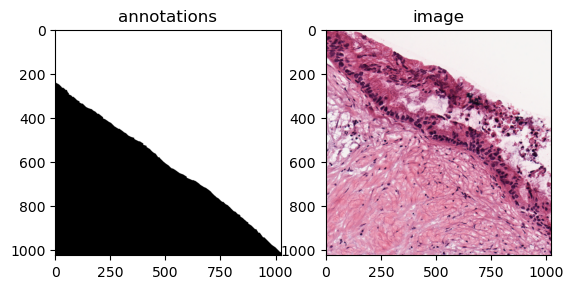

In [13]:
annotation = cv2.imread(train_mask_path[0])
image = cv2.imread(train_img_path[0])
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.subplot(1,2,1)
plt.title("annotations")
plt.imshow(annotation)

plt.subplot(1,2,2)
plt.title("image")
plt.imshow(image)

In [14]:
# Custom Dataset
class CustomDataset(Dataset):
    def __init__(self, img_path, mask_path, transform = None):
        self.image = img_path
        self.mask = mask_path
        
        n_samples =  len(self.image)
        
        # 데이터 미리 섞어줌
        np.random.seed(CFG['SEED'])
        idxs = np.random.permutation(range(n_samples))
        
        self.image = np.array(self.image)[idxs]
        self.mask = np.array(self.mask)[idxs]
        self.transform = transform

    def __len__(self):
        return len(self.image) # 데이터셋 길이
    
    def __getitem__(self, i):
        image = np.array(Image.open(self.image[i]))
        mask = np.array(Image.open(self.mask[i]))
        data = self.transform(image = image, mask = mask)
        image = data["image"]
        mask = data["mask"]
        return image, mask

## 데이터 불러오기

In [15]:
# transform
train_transform = A.Compose([
        A.Resize(CFG['IMG_SIZE'],CFG['IMG_SIZE']),
        A.Normalize(mean=CFG['MEAN'], std = CFG['STD']),
        A.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
        A.OneOf([
                A.HorizontalFlip(p=0.3),
                A.RandomRotate90(p=0.3),
                A.VerticalFlip(p=0.3)            
        ], p=0.3),
        ToTensorV2(transpose_mask=True)
])

'''
A.OneOf([
        A.MotionBlur(p=0.3),
        A.OpticalDistortion(p=0.3),
        A.GaussNoise(p=0.3)                 
], p=0.3),
'''

'\nA.OneOf([\n        A.MotionBlur(p=0.3),\n        A.OpticalDistortion(p=0.3),\n        A.GaussNoise(p=0.3)                 \n], p=0.3),\n'

In [16]:
val_transform = A.Compose([
        A.Resize(CFG['IMG_SIZE'],CFG['IMG_SIZE']),
        A.Normalize(mean=CFG['MEAN'], std = CFG['STD']),
        ToTensorV2(transpose_mask=True)
])

In [17]:
# 학습용 데이터
train_set = CustomDataset(img_path = train_img_path,
                          mask_path = train_mask_path,
                          transform = train_transform)

val_set = CustomDataset(img_path = val_img_path,
                         mask_path= val_mask_path,
                         transform = val_transform)

In [18]:
train_loader = DataLoader(train_set, batch_size = CFG["BATCH_SIZE"], shuffle = True)
val_loader = DataLoader(val_set, batch_size = CFG["BATCH_SIZE"])

In [19]:
print(f"train_data : {len(train_set)} / val_data : {len(val_set)}")

train_data : 5335 / val_data : 260


## 학습

In [20]:
# Modeling
class ResUNet(nn.Module):
    def __init__(self, num_classes):
        super(ResUNet, self).__init__()
        self.encoder = models.resnet18(pretrained=True)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.relu = nn.ReLU(inplace=True)
        self.upconv1 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.conv1 = nn.Conv2d(512, 256, kernel_size=3, padding=1)
        self.upconv2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(256, 128, kernel_size=3, padding=1)
        self.upconv3 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.conv3 = nn.Conv2d(128, 64, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(64, num_classes, kernel_size=1)

    def forward(self, x):
        # Encoder
        x1 = self.encoder.conv1(x)
        x1 = self.encoder.bn1(x1)
        x1 = self.encoder.relu(x1)
        x1 = self.encoder.maxpool(x1)

        x2 = self.encoder.layer1(x1)
        x3 = self.encoder.layer2(x2)
        x4 = self.encoder.layer3(x3)
        x5 = self.encoder.layer4(x4)

        # Decoder
        x = self.upconv1(x5)
        x = torch.cat((x, x4), dim=1)
        x = self.relu(self.conv1(x))

        x = self.upconv2(x)
        x = torch.cat((x, x3), dim=1)
        x = self.relu(self.conv2(x))

        x = self.upconv3(x)
        x = torch.cat((x, x2), dim=1)
        x = self.relu(self.conv3(x))

        x = self.conv4(x)

        # Resize to 512x512
        x = nn.functional.interpolate(x, size=(1024, 1024), mode='bilinear', align_corners=False)

        return x

In [21]:
class DiceLoss(nn.Module):
    def __init__(self):
        super(DiceLoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):
        
        inputs = F.sigmoid(inputs) # sigmoid를 통과한 출력이면 주석처리
        
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        
        intersection = (inputs * targets).sum()                            
        dice = (2.*intersection + smooth) / (inputs.sum() + targets.sum() + smooth)  
        
        return 1 - dice 

In [23]:
# 학습 파라미터
model = ResUNet(num_classes=1).to(device)
model = nn.DataParallel(model)
optimizer = Adam(params = model.parameters(), lr = CFG["LEARNING_RATE"])
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=2, threshold_mode='abs', min_lr=1e-8, verbose=True)
criterion = DiceLoss().to(device)

/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/data_parallel.py:32: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 2 which
    has less than 75% of the memory or cores of GPU 1. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


In [24]:
def dice_score(pred, target, smooth=1e-6):
    intersection = (pred * target).sum()
    union = pred.sum() + target.sum()
    dice = (2.0 * intersection + smooth) / (union + smooth)
    return dice

In [25]:
# 평균값 계산
class AverageMeter: 
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [26]:
class EarlyStop:
    def __init__(self, patience=5, delta=0):
        self.patience = patience
        self.delta = delta
        self.best_score = None
        self.counter = 0
        self.early_stop = False
        self.val_loss_min = np.Inf

    def __call__(self, val_score):
        if self.best_score is None:
            self.best_score = val_score
        elif val_score < self.best_score + self.delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = val_score
            self.counter = 0

In [27]:
loss_meter = AverageMeter()
score_meter = AverageMeter()
early_stopping = EarlyStop(patience = 20, delta = 0)

In [28]:
def validation(model, criterion, val_loader, device):
    model.eval()
    with torch.no_grad():
        for img, label in tqdm(val_loader):
            out = model(img.to(device))
            out = torch.squeeze(out)
            pred = torch.ge(out.sigmoid(), 0.5).float()
            label = torch.squeeze(label).to(device)
            score = dice_score(pred, label)
            loss = criterion(out, label.type(torch.FloatTensor).to(device))

            loss_meter.update(loss.item())
            score_meter.update(score.item())

        val_loss_mean = loss_meter.avg
        val_score_mean = score_meter.avg
        loss_meter.reset()
        score_meter.reset()
    return val_loss_mean, val_score_mean

In [29]:
def train(model, criterion, optimizer, train_loader, val_loader, scheduler, device):
    best_score = 0
    best_model = None
    result_arr = np.empty((0,4), float)
    columns = []
    model.train()
    for epoch in range(CFG["EPOCHS"]):
        try:
            for img, label in tqdm(train_loader):
                optimizer.zero_grad()
                out = model(img.to(device))
                out = torch.squeeze(out)
                pred = torch.ge(out.sigmoid(), 0.5).float()
                label = torch.squeeze(label).to(device)
                score = dice_score(pred, label)
                loss = criterion(out, label.type(torch.FloatTensor).to(device))

                loss_meter.update(loss.item())
                score_meter.update(score.item())

                loss.backward()
                optimizer.step()
                
            train_loss_mean = loss_meter.avg
            train_score_mean = score_meter.avg
            loss_meter.reset()
            score_meter.reset()
            val_loss, val_score = validation(model, criterion, val_loader, device)

            print(f"epoch{epoch+1}: Train_loss:{train_loss_mean} Train_score:{train_score_mean} Val_loss:{val_loss} Val_score:{val_score}")
            result_arr = np.append(result_arr, np.array([[train_loss_mean,train_score_mean, val_loss, val_score]]), axis = 0)
            if scheduler is not None:
                scheduler.step(val_score)
                  
            if best_score < val_score:
                best_score = val_score
                best_model = model
                
            early_stopping(val_score)
            if early_stopping.early_stop:
                columns.append(f"epoch:{epoch+1}")
                print("Early stopping!")
                break
        except KeyboardInterrupt:
            best_model = model
        columns.append(f"epoch:{epoch+1}")
    return best_model, result_arr, columns

## Run

In [30]:
infer_model, result, columns = train(model, criterion, optimizer, train_loader, val_loader, scheduler, device)

  0%|          | 0/167 [00:02<?, ?it/s]


OutOfMemoryError: Caught OutOfMemoryError in replica 0 on device 0.
Original Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py", line 64, in _worker
    output = module(*input, **kwargs)
  File "/opt/conda/lib/python3.10/site-packages/torch/nn/modules/module.py", line 1501, in _call_impl
    return forward_call(*args, **kwargs)
  File "/tmp/ipykernel_78982/458064922.py", line 23, in forward
    x2 = self.encoder.layer1(x1)
  File "/opt/conda/lib/python3.10/site-packages/torch/nn/modules/module.py", line 1501, in _call_impl
    return forward_call(*args, **kwargs)
  File "/opt/conda/lib/python3.10/site-packages/torch/nn/modules/container.py", line 217, in forward
    input = module(input)
  File "/opt/conda/lib/python3.10/site-packages/torch/nn/modules/module.py", line 1501, in _call_impl
    return forward_call(*args, **kwargs)
  File "/opt/conda/lib/python3.10/site-packages/torchvision/models/resnet.py", line 97, in forward
    out = self.bn2(out)
  File "/opt/conda/lib/python3.10/site-packages/torch/nn/modules/module.py", line 1501, in _call_impl
    return forward_call(*args, **kwargs)
  File "/opt/conda/lib/python3.10/site-packages/torch/nn/modules/batchnorm.py", line 171, in forward
    return F.batch_norm(
  File "/opt/conda/lib/python3.10/site-packages/torch/nn/functional.py", line 2450, in batch_norm
    return torch.batch_norm(
torch.cuda.OutOfMemoryError: CUDA out of memory. Tried to allocate 176.00 MiB (GPU 0; 11.76 GiB total capacity; 9.77 GiB already allocated; 63.00 MiB free; 10.23 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF


## 결과 그래프

In [46]:
result_df = pd.DataFrame(data = result, index = columns, columns = ["Train Loss", "Train Dice Score", "Validation Loss", "Validation Dice Score"])
result_df.tail()

,Train Loss,Train Dice Score,Validation Loss,Validation Dice Score
epoch:16,0.100209,0.900210,0.254576,0.745940
epoch:17,0.098681,0.901740,0.247981,0.752524
epoch:18,0.095415,0.904980,0.243411,0.757409
epoch:19,0.092427,0.907968,0.245707,0.754827
epoch:20,0.089620,0.910765,0.260583,0.739862


<Axes: >

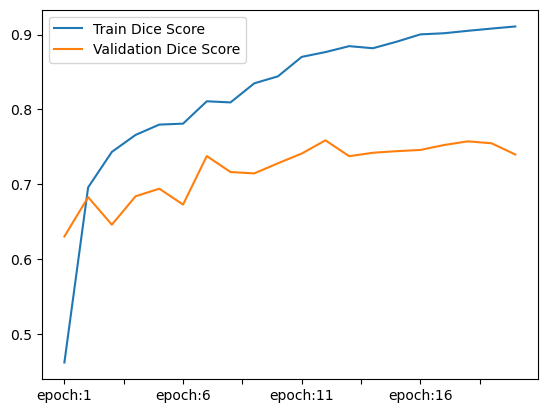

In [47]:
result_df[["Train Dice Score", "Validation Dice Score"]].plot()

<Axes: >

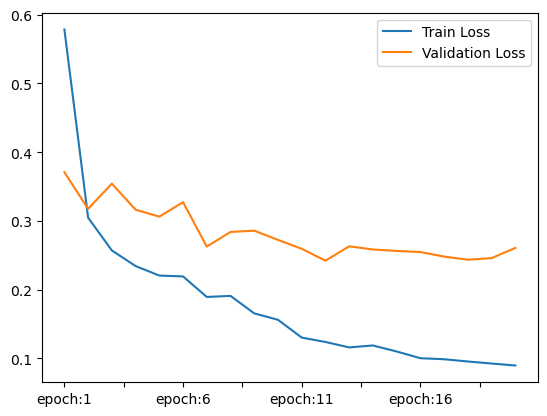

In [48]:
result_df[["Train Loss", "Validation Loss"]].plot()

## 결과 저장

In [49]:
# 데이터프레임 저장
os.makedirs(f"{output_path}", exist_ok=True)
os.makedirs(f"{trainframe_path}", exist_ok=True)
result_df.to_excel(f"{trainframe_name}")

In [50]:
# 모델 저장
os.makedirs(f"{pth_path}", exist_ok=True)
torch.save(infer_model.state_dict(), pth_name)